In [1]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import typing

# Настройки для визуализации
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [2]:
# Просмотрим структуры папок
# В директории trainingSet лежат папки с номерами, которые, по сути, являются разметкой

from pathlib import Path
import os

training_set_dirpath = Path("mnist_dataset") / Path("trainingSet") / Path("trainingSet")

directories_list = os.listdir(training_set_dirpath)
print(training_set_dirpath, directories_list)

mnist_dataset\trainingSet\trainingSet ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Shape: (28, 28, 3)
Type: <class 'numpy.ndarray'>


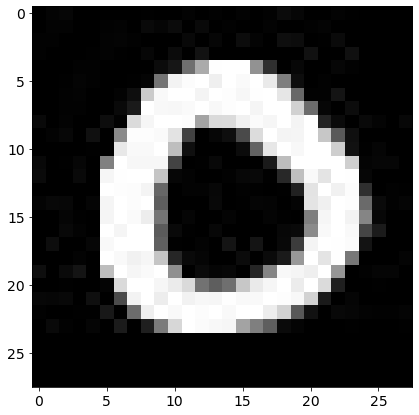

In [8]:
image_path = training_set_dirpath / Path("0") / Path("img_4.jpg")

import cv2

image = cv2.imread(str(image_path))

plt.figure(figsize=(7,7))
plt.imshow(image)

print(f"Shape: {image.shape}")
print(f"Type: {type(image)}")

Изображения представляют собой массив numpy размера (28, 28, 3). 
Для проверки правильности разметки просмотрим по несколько изображений из каждой папки и сравним с названием папки.

In [9]:
def extract_N_random_class_images(dirpath: Path, N: int) -> typing.List[str]:

    '''Функция получения N случайных путей до изображений каждого класса'''   

    training_set_dirpath = Path("mnist_dataset") / Path("trainingSet") / Path("trainingSet")
    img_paths = []

    for folder in dirpath.iterdir():
        for _ in range(N):
            files = os.listdir(folder)
            index = random.randrange(0, len(files))
            img_paths.append(str(folder / Path(files[index])))
        
    return img_paths

In [10]:
# TEST

fpath_list = extract_N_random_class_images(training_set_dirpath, 3)
assert len(fpath_list) == 3*10
assert all([os.path.exists(fpath)for fpath in fpath_list])

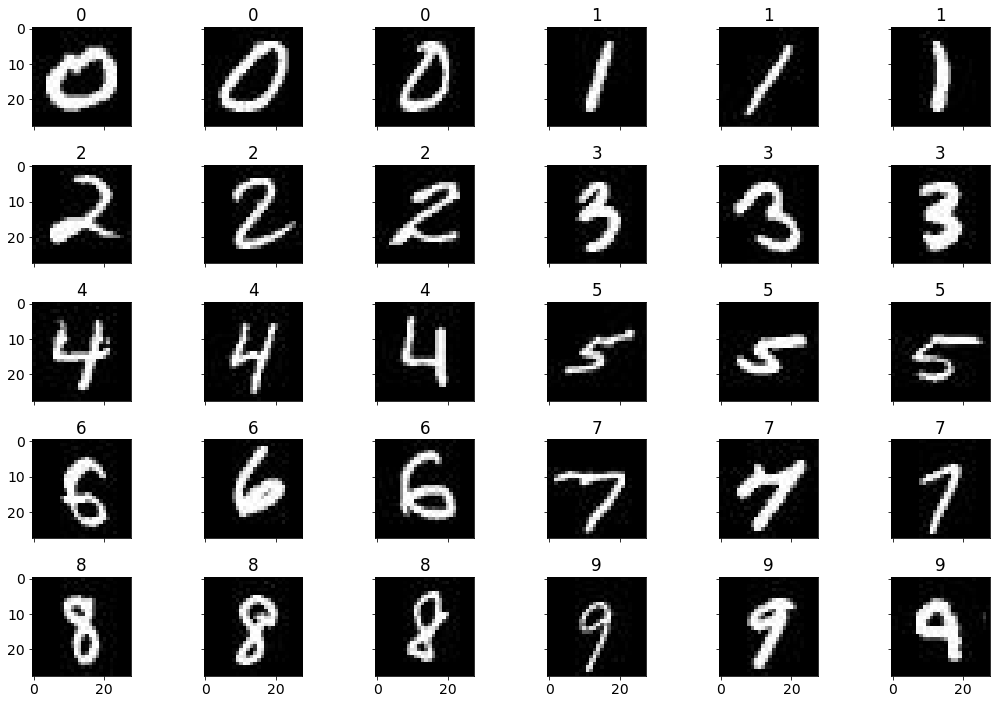

In [11]:
fpath_list = extract_N_random_class_images(training_set_dirpath, 3)

fig, ax = plt.subplots(nrows=5, ncols=6, sharex=True, sharey=True, )
for i, fpath in enumerate(fpath_list):
    _img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    
    class_name = Path(fpath).parts[-2]

    r,c = i//6,i%6
    ax[r,c].imshow(_img, cmap='gray')
    ax[r,c].set_title(class_name)
plt.tight_layout()

Видим, что ошибок в разметке не наблюдается.

Для работы в PyTorch необходимо выполнить предобработку изображений:
    Превратить массив numpy в тензор типа float
    Произвести нормировку изображения для более качественного обучения сети
    Изменить формат данных HWC -> CHW

In [12]:
def preprocess_image_2_tensor(img: np.ndarray) -> torch.Tensor:
    '''Функция предобработки изображений (HWC -> CHW)
    img - массив numpy с размерностями HWC
    H - высота изображения
    W - ширина изображения
    C - количество каналов в изображении'''
    
    img = torch.tensor(img).float().permute(2,0,1)
    img = torch.div(img, 255) # Нормализация [0;1]
        
    return img

In [13]:
# TEST
rng = np.random.default_rng(RANDOM_STATE)

_test_arr = rng.random((40, 40, 2))
_test_tnsr = preprocess_image_2_tensor(_test_arr)

np.testing.assert_array_almost_equal(_test_tnsr.shape, (2, 40, 40))
assert torch.is_tensor(_test_tnsr)

Напишем реализацию класса для подготовки изображений

In [14]:
class DigitsDataset(torch.utils.data.Dataset):
    def __init__(self, dirpath: Path):
        # В конструкторе сформируем список путей до файлов
        self.path_list = []
        for folder in dirpath.iterdir():
            files = os.listdir(folder)
            for image in files:
                self.path_list.append(str(folder / Path(image)))
        
    def __len__(self) -> int:
        # Количество изображений в наборе
        return len(self.path_list)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, int]:
        # Изображение и разметка по индексу
        
        _img = cv2.imread(self.path_list[index], cv2.IMREAD_GRAYSCALE)
        _img = np.expand_dims(_img, axis=2) # OpenCV читает в формате HW -> +1 размерность
        _img = torch.tensor(_img).float().permute(2,0,1)
        img_tnsr = torch.div(_img, 255)
        
        label = Path(self.path_list[index]).parts[-2]
        
        return img_tnsr, label

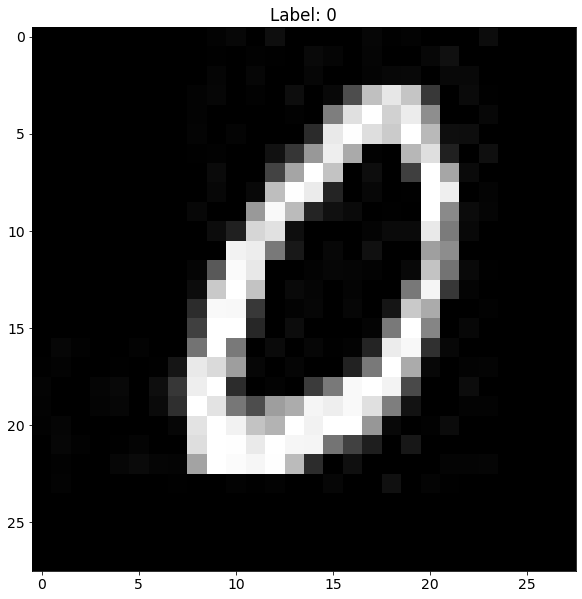

In [15]:
# TEST
digits_dataset = DigitsDataset(training_set_dirpath)

img_tnsr, label = digits_dataset[100]

assert torch.is_tensor(img_tnsr)
np.testing.assert_array_almost_equal(img_tnsr.shape, torch.Size((1, 28, 28)))
np.testing.assert_almost_equal(img_tnsr.max(), 1)
np.testing.assert_almost_equal(img_tnsr.min(), 0)

# Вернём обратно из тензора в изображение, чтобы отобразить
def tensor_2_image(tnsr: torch.Tensor) -> np.ndarray:
    img = tnsr.permute(1, 2, 0).numpy()
    img = (img*255).astype(np.uint8)
    return img

_img = tensor_2_image(img_tnsr)

plt.imshow(_img[..., 0], cmap='gray')
plt.title(f'Label: {label}')
plt.show()

Цифра сходится с надписью, следовательно все подготовлено верно!

Составим нейронную сеть. Сеть будет состоять из двух слоев, каждый из которых будет иметь нелинейность типа ReLU и слой пулинга. 

In [16]:
class MyFirstConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(RANDOM_STATE)
        # Первый блок свертки
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # После пулинга размер из 28х28 преобразуется в 14х14

        # Второй блок свертки
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # После пулинга размер из 14х14 преобразуется в 7х7
        
        # fc ~ fully connected block
        self.fc = nn.Sequential(
            # Первый слой для входа - это выпрямленный вектор
            # Размер выбирается исходя из предыдущего слоя
            # H*W*C, HxW = 7x7, C = кол-во каналов на пред. слое
            nn.Linear(7*7*32, 500),
            nn.Sigmoid(),
            # Выход последнего слоя по количеству предсказываемых классов
            # Размерность выхода - NK (K=10)
            nn.Linear(500, 10)
            # Предсказаны Logits - сырые степени уверенности
        )
    
    def forward(self, x):
        # Предсказания блоков
        out = self.layer1(x)
        out = self.layer2(out)
        # Делаем flattening результатов
        # Из NCHW делаем NV
        # N - размер батча, V = C*H*W
        out = out.reshape(out.size(0), -1)
        # Предсказания последним блоком
        out = self.fc(out)
        return out

In [17]:
# TEST - просто проверить, что работает =)
model = MyFirstConvNet()

# Сделаем случайный батч для проверки
# 2 записи в батче, CHW - соответсвует нашим картинкам
X_rndm_batch = torch.randn((2, 1, 28, 28), dtype=torch.float)
y_pred = model(X_rndm_batch)

assert np.all(y_pred.shape == torch.Size((2, 10)))

Разделим директорию с файлами на три директории. Это необходимо для фомирования наборов данных для обучения, теста и валидации. Соотношение объемов выборок 60-20-20.

In [18]:
from sklearn.model_selection import train_test_split
import shutil

def split_data(dirpath: Path, new_dir_name: str) -> typing.Tuple[Path, Path, Path]:
    labels = []
    paths = []
    
    for class_path in dirpath.iterdir():
        class_label = class_path.parts[-1]
        for path in class_path.iterdir():
            paths.append(path)
            labels.append(class_label)

    all_idxs = range(len(paths))

    train_idxs, test_idxs = train_test_split(
        all_idxs, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
    )

    train_val_idxs = [all_idxs[i] for i in train_idxs]
    train_val_labels = [labels[i] for i in train_idxs]

    train_idxs, val_idxs = train_test_split(
        train_val_idxs, test_size=0.25, random_state=RANDOM_STATE,
        stratify=train_val_labels
    )

    print(f'Train size: {len(train_idxs)}')
    print(f'Val size: {len(val_idxs)}')
    print(f'Test size: {len(test_idxs)}')

    # Индексы разделили, теперь можно скопировать файлы в новые директории

    new_dataset = Path(new_dir_name)

    train_dataset = new_dataset / Path("train")
    valid_dataset = new_dataset / Path("valid")
    test_dataset = new_dataset / Path("test")

    dataset_idx_pairs = [
        (train_dataset, train_idxs),
        (valid_dataset, val_idxs),
        (test_dataset, test_idxs),
    ]

    for target_dataset_dirpath, idxs in dataset_idx_pairs:
        target_dataset_dirpath.mkdir(parents=True, exist_ok=True)

        for idx in idxs:
            path = paths[idx]
            label = labels[idx]

            class_path = target_dataset_dirpath / Path(label)
            new_path = class_path / path.name

            class_path.mkdir(exist_ok=True)
            shutil.copyfile(path, new_path)

    return train_dataset, valid_dataset, test_dataset

In [19]:
train_dirpath, valid_dirpath, test_dirpath = split_data(training_set_dirpath, new_dir_name="splitted")

Train size: 25200
Val size: 8400
Test size: 8400


Подготовим загрузчики данных

In [20]:
def prepare_loaders(config):
    # Обратите внимание тут мы передаем конфиг, в котором прописаны параметры обучения
    train_dirpath = config['train_dirpath']
    valid_dirpath = config['valid_dirpath']
    test_dirpath = config['test_dirpath']
    batch_size = config['batch_size']

    # Готовим загрузчики для каждой выборки
    train_loader = torch.utils.data.DataLoader(
        dataset=DigitsDataset(train_dirpath),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        dataset=DigitsDataset(valid_dirpath),
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        dataset=DigitsDataset(test_dirpath),
        batch_size=batch_size,
        shuffle=True
    )

    return train_loader, val_loader, test_loader

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
def train_epoch(model, loader, loss, optim, device):

    '''Функция обучения одной эпохи'''
    
    history = {
        'loss': []
    }

    # Таким образом переводим модель в режим обучения
    # В этом режиме вычисляются градиенты, нужные для обучения
    model.train()
    for imgs_batch, labels_batch in loader:
        imgs_batch = imgs_batch.to(device)
        labels_batch = np.array(labels_batch, dtype=float)
        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
        labels_batch = labels_batch.to(device)

        pred = model(imgs_batch)

        loss = loss_op(pred, labels_batch)
        # Сохраним в историю эпохи
        history['loss'].append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return history

def valid_epoch(model, loader, loss, device):
    history = {
        'loss': []
    }

    # Таким образом переводим модель в режим исполнения (inference)
    # В этом режиме отключены градиенты, он быстрее, 
    #   но в нём нельзя обучать модель
    model.eval()
    for imgs_batch, labels_batch in loader:
        imgs_batch = imgs_batch.to(device)
        labels_batch = np.array(labels_batch, dtype=float)
        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
        labels_batch = labels_batch.to(device)
        
        pred = model(imgs_batch)

        loss = loss_op(pred, labels_batch)
        # Сохраним в историю эпохи
        history['loss'].append(loss.item())
    
    return history

In [23]:
# TEST
config = {
    'lr': 0.01,
    # Для проверки - 2 эпохи
    'epochs': 2,
    "batch_size": 32,

    "train_dirpath": train_dirpath,
    "valid_dirpath": valid_dirpath,
    "test_dirpath": test_dirpath,
}

train_loader, val_loader, test_loader = prepare_loaders(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyFirstConvNet()
model.to(device)

loss_op = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=config['lr'])

history = {
    'train_loss': [],
    'val_loss': []
}

for epoch in range(config['epochs']):
    # Сначала выполняем цикл обучения
    epoch_train_history = train_epoch(model, train_loader, loss_op, optim, device)
    # Затем исполняем цикл валидации
    epoch_val_history = valid_epoch(model, val_loader, loss_op, device)

    # В историю обучения попадает среднее по эпохе значение
    epoch_train_loss = np.mean(epoch_train_history['loss'])
    epoch_val_loss = np.mean(epoch_val_history['loss'])
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)

    print(f'Epoch {epoch}:')
    print(f'  Train loss: {epoch_train_loss}')
    print(f'  Valid loss: {epoch_val_loss}')

print(history)

Epoch 0:
  Train loss: 2.3017761689152207
  Valid loss: 2.27875298420286
Epoch 1:
  Train loss: 1.9293337492319533
  Valid loss: 0.9615529596578939
{'train_loss': [2.3017761689152207, 1.9293337492319533], 'val_loss': [2.27875298420286, 0.9615529596578939]}


In [24]:
def evaluate_batch_accuracy(y_pred, y_true):
    '''
    Функция для Оценки точности предсказания (accuracy)
    y_pred:
        батч сырых степеней уверенности, размер (N, K)
    y_true:
        вектор истинных значений, размер (N)
    '''
    y_pred_val, y_pred_idx = torch.max(y_pred, dim=1)
    accuracy = sum(torch.eq(y_pred_idx, y_true)) / len(y_true)
    return float(accuracy)

In [25]:
# TEST

y_true = torch.tensor([1, 2, 1])
y_pred = torch.tensor([
    [0, 0, 0, 2],
    [10, 10, 12, 0],
    [1, 10, -1, 2]
]).float()

np.testing.assert_almost_equal(evaluate_batch_accuracy(y_pred, y_true), 0.66, decimal=2)

In [26]:
def evaluate_loader(model, loader, device):
    '''
        Функция оценки данных в загрузчике
    '''
    metrics = {
        'accuracy': []
    }

    model.eval()
    for imgs_batch, labels_batch in loader:
        labels_batch = np.array(labels_batch, dtype=float)
        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
        labels_batch = labels_batch.to(device)

        y_pred = model(imgs_batch)
        acc = evaluate_batch_accuracy(y_pred, labels_batch)
        metrics['accuracy'].append(acc)
        
    return metrics

In [27]:
# TEST
config = {
    'lr': 0.01,
    # Для проверки - 2 эпохи
    'epochs': 2,
    "batch_size": 32,

    "train_dirpath": train_dirpath,
    "valid_dirpath": valid_dirpath,
    "test_dirpath": test_dirpath,
}

_, val_loader, _ = prepare_loaders(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyFirstConvNet()
model.to(device)
epoch_metrics = evaluate_loader(model, val_loader, device)

# Усредним точности на батчах
epoch_mean_accuracy = np.mean(epoch_metrics['accuracy'])

np.testing.assert_almost_equal(epoch_mean_accuracy, 0.1, decimal=1)

Выполним обучение сети

In [28]:
# Обучение
config = {
    'lr': 0.01,
    'epochs': 50,
    # Возьмем побольше
    "batch_size": 128,

    "train_dirpath": train_dirpath,
    "valid_dirpath": valid_dirpath,
    "test_dirpath": test_dirpath,
}

torch.manual_seed(RANDOM_STATE)
train_loader, val_loader, test_loader = prepare_loaders(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyFirstConvNet()
model.to(device)

loss_op = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=config['lr'])

history = {
    'train_loss': [],
    'val_loss': [],
    'accuracy': []
}

for epoch in range(config['epochs']):
    epoch_train_history = train_epoch(model, train_loader, loss_op, optim, device)
    epoch_val_history = valid_epoch(model, val_loader, loss_op, device)
    epoch_metrics = evaluate_loader(model, val_loader, device)

    # В историю обучения попадает среднее по эпохе значение
    epoch_train_loss = np.mean(epoch_train_history['loss'])
    epoch_val_loss = np.mean(epoch_val_history['loss'])
    epoch_accuracy = np.mean(epoch_metrics['accuracy'])

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['accuracy'].append(epoch_accuracy)

    print(f'Epoch {epoch}:')
    print(f'  Train loss: {epoch_train_loss}')
    print(f'  Valid loss: {epoch_val_loss}')
    print(f'  Accuracy: {epoch_accuracy}')

Epoch 0:
  Train loss: 2.3034415148236427
  Valid loss: 2.2989124673785586
  Accuracy: 0.11155303025787527
Epoch 1:
  Train loss: 2.2982444315392354
  Valid loss: 2.2958054542541504
  Accuracy: 0.09824810606060606
Epoch 2:
  Train loss: 2.293568261383754
  Valid loss: 2.28810783588525
  Accuracy: 0.10459280307545807
Epoch 3:
  Train loss: 2.283391124705978
  Valid loss: 2.275025057070183
  Accuracy: 0.2104166667118217
Epoch 4:
  Train loss: 2.2604460099021795
  Valid loss: 2.2396093968189126
  Accuracy: 0.30035511381698377
Epoch 5:
  Train loss: 2.191744329965659
  Valid loss: 2.1143732648907285
  Accuracy: 0.5347064390326991
Epoch 6:
  Train loss: 1.9310364348029123
  Valid loss: 1.6545925122318845
  Accuracy: 0.711979167027907
Epoch 7:
  Train loss: 1.2772744854694695
  Valid loss: 0.9466124800118533
  Accuracy: 0.790104167027907
Epoch 8:
  Train loss: 0.7839644962761003
  Valid loss: 0.6604570430336576
  Accuracy: 0.8301846592715292
Epoch 9:
  Train loss: 0.5911292379277612
  Valid 

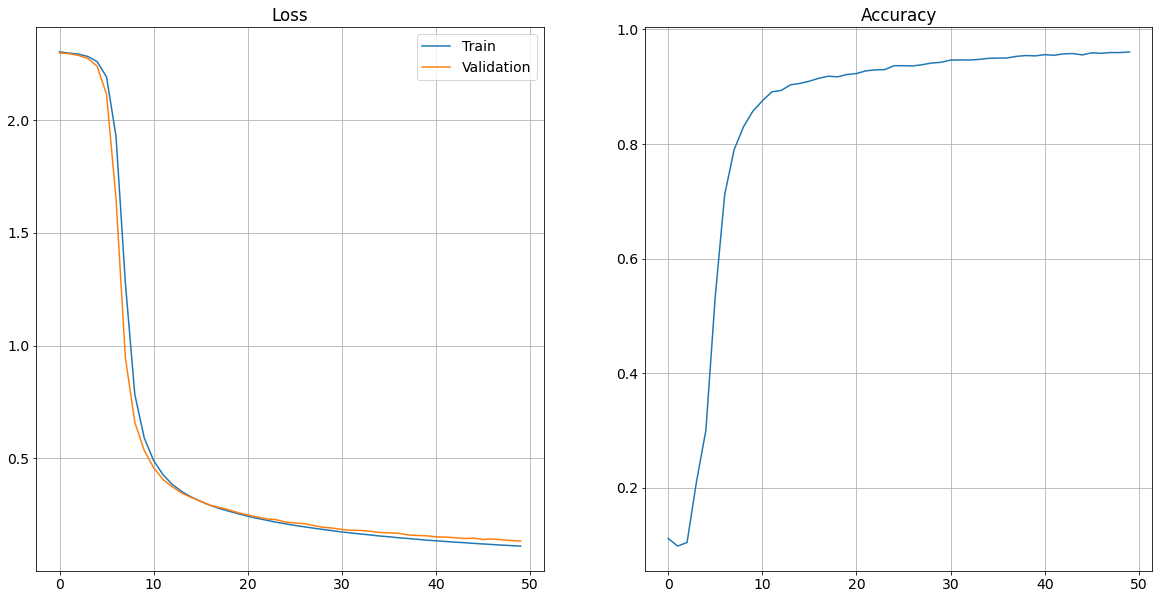

In [29]:
plt.figure(figsize=[20,10])

plt.subplot(121)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(history['accuracy'])
plt.title('Accuracy')
plt.grid()

plt.show()

Произведем оценку модели на тестовой выборке

In [30]:
epoch_metrics = evaluate_loader(model, test_loader, device)

epoch_mean_accuracy = np.mean(epoch_metrics['accuracy'])
print(f'Test acuracy: {epoch_mean_accuracy}')

Test acuracy: 0.9637073865442565


Произведем анализ полученных ошибок

In [31]:
y_true = []
y_pred = []
# Сразу с созданием вектора предсказаний соберем инфу об ошибках
err_img_triplets = []

model.eval()
for imgs_batch, labels_batch in test_loader:
    imgs_batch = imgs_batch.to(device)
    labels_batch = np.array(labels_batch, dtype=float)
    labels_batch = torch.tensor(labels_batch, dtype=torch.long)
    labels_batch = labels_batch.to(device)
    
    pred = model(imgs_batch)
    _, pred_labels = torch.max(pred, dim=1)
    
    for i in range(imgs_batch.shape[0]):
        y_true.append(labels_batch[i].item())
        y_pred.append(pred_labels[i].item())

        if y_true[-1] != y_pred[-1]:
            err_img_triplets.append(
                (imgs_batch[i].cpu(), y_true[-1], y_pred[-1])
            )

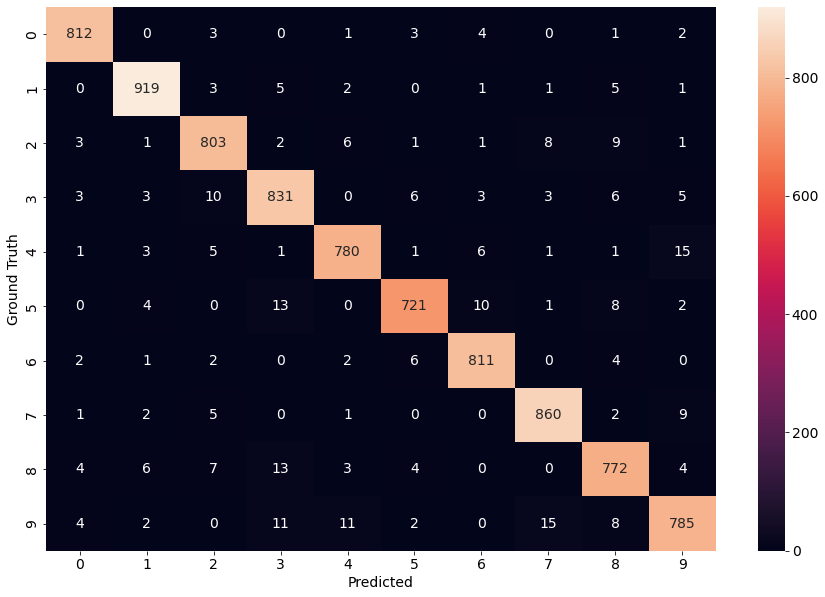

In [32]:
from sklearn.metrics import confusion_matrix

conf_mtrx = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mtrx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.show()

По матрице ошибок можно определить, в каких случаях модель ошибается чаще

In [33]:
from sklearn.metrics import classification_report

rep = classification_report(y_true, y_pred, digits=4)
print(rep)

              precision    recall  f1-score   support

           0     0.9783    0.9831    0.9807       826
           1     0.9766    0.9808    0.9787       937
           2     0.9582    0.9617    0.9600       835
           3     0.9486    0.9552    0.9519       870
           4     0.9677    0.9582    0.9630       814
           5     0.9691    0.9499    0.9594       759
           6     0.9701    0.9795    0.9748       828
           7     0.9674    0.9773    0.9723       880
           8     0.9461    0.9496    0.9478       813
           9     0.9527    0.9368    0.9446       838

    accuracy                         0.9636      8400
   macro avg     0.9635    0.9632    0.9633      8400
weighted avg     0.9636    0.9636    0.9635      8400



Взглянем на ошибки

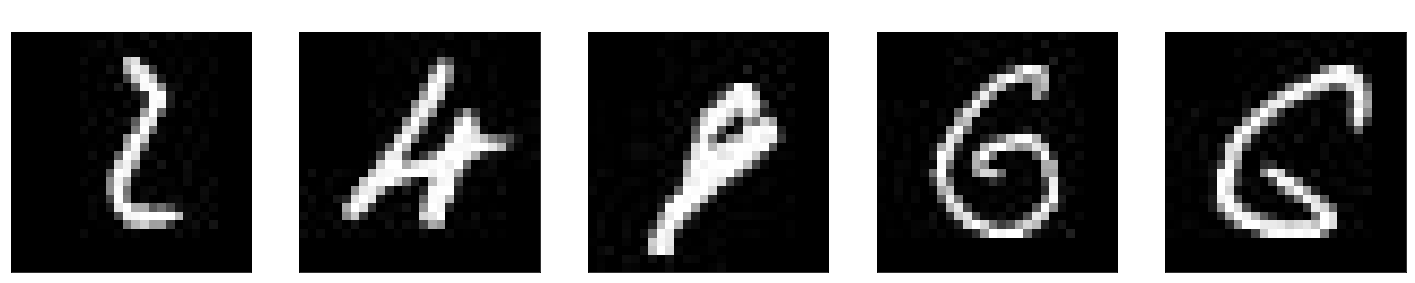

In [34]:
from turtle import color


plt.figure(figsize=[25, 10])
subplot = 1

for img_tnsr, true_label, pred_label in err_img_triplets[:5]:
    img = img_tnsr.permute(1, 2, 0).mul(255).numpy().astype(np.uint8)

    plt.subplot(1, 5, subplot)
    subplot += 1

    plt.imshow(img[..., 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True: {true_label}, predicted: {pred_label}', color='w', fontsize='xx-large')
plt.show()

Сохраним модель в файл

In [ ]:
SAVE_PATH = 'Digits_classification_CNN.pth'
# Вызываем функцию сохранения
# Сохраняем параметры модели!
torch.save(model.state_dict(), SAVE_PATH)